In [1]:
# %load ../../../../../my_imports.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

Seurat23 = ['#c77fb0', '#59aa4e', '#914187', '#82ac33', '#8a619f',
            '#3bb0be', '#4d599d', '#e17a21', '#7386be', '#d7a437',
            '#704a90', '#417f34', '#c13f86', '#5eb17d', '#dd2d63',
            '#50b4a9', '#d5333a', '#445298', '#cd802e', '#bcb335',
            '#89802b', '#9e3f84', '#9eab5e']

Kelly = ['#af2337', '#ecc342', '#2967a0', '#2f3c28', '#96b437',
         '#da93ab', '#e58932', '#80598f', '#7e331f', '#3b855a',
         '#c0b286', '#a9c9ed', '#ec977f', '#848482', '#604628',
         '#d26034', '#a64c6b', '#dbd245', '#eba83b', '#5d5092',
         '#222222', '#f2f3f4']

GreenArmytage = ['#e3a7fa', '#3575d5', '#8d4418', '#440b59', '#191919', '#285a35',
                 '#6aca5b', '#f6cda0', '#808080', '#b1fcbb', '#8c7c26', '#a8ca3f',
                 '#af2785', '#13347b', '#51a12f', '#f1acbb', '#4b651a', '#e73329',
                 '#8deef0', '#48978f', '#e7fd7d', '#0c1ff5', '#8a1a11', '#fffe92',
                 '#f9e14c', '#e95d2a']

Chromsomes = ['#fefb57', '#c15662', '#b3bff5', '#75f9f0', '#ea8a33',
              '#9e5dca', '#946e6b', '#f3c985', '#f0feee', '#afe347',
              '#5dc5e5', '#e73ff0', '#e23022', '#ed7fc5', '#4f8283',
              '#af35f5', '#49a9f6', '#ea3584', '#94f8b8', '#4d6df6',
              '#eafdad', '#f6c6ec', '#5d8841', '#74f973']

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.markerscale'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['figure.dpi'] = 90

In [2]:
sns.set_style('ticks')

# Collect information from different files

In [4]:
# collect information

mCortex_all = pd.read_csv('scripts_data/mCortex_all_metadata.csv', index_col=0)
rna_umap_pos = pd.read_csv('scripts_data/mCortex_all_RNA_UMAP_coordinates.csv', skiprows=1, header=None, names=['', 'RNA_UMAP1', 'RNA_UMAP2'], index_col=0)
atac_umap_pos = pd.read_csv('scripts_data/mCortex_all_ATAC_UMAP_coordinates.csv', skiprows=1, header=None, names=['', 'ATAC_UMAP1', 'ATAC_UMAP2'], index_col=0)

In [5]:
sample_info = pd.concat([mCortex_all, rna_umap_pos, atac_umap_pos], axis=1)
sample_info.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_ATAC,nFeature_ATAC,TSS.enrichment,TSS.percentile,nucleosome_signal,nucleosome_percentile,...,prediction.score.Meis2,prediction.score.Astro,prediction.score.Macrophage,prediction.score.VLMC,prediction.score.SMC,prediction.score.max,RNA_UMAP1,RNA_UMAP2,ATAC_UMAP1,ATAC_UMAP2
CCCTAGTTCGTTGTTT-1,mCortex,8962,3118,0.044633,37507,17803,4.800166,0.90,0.809613,0.41,...,0.0,0.0,0.0,0.0,0.0,0.884048,4.970075,-1.014443,-2.815630,-11.721750
GCTGTTCTCGTTGTTT-1,mCortex,3800,1806,0.000000,23586,11714,3.657436,0.48,0.763252,0.31,...,0.0,0.0,0.0,0.0,0.0,0.838312,1.341941,3.214174,0.719105,0.385731


In [6]:
sample_info['batch'] = sample_info.index.str.extract('[ACGT]{16}(-.*)', expand=False)
sample_info.replace({'batch': {'-1' : 'mCortex_rep1', '-2' : 'mCortex_rep2'}}, inplace = True)
sample_info['RNA_Cluster'] = 'R' + sample_info['RNA_snn_res.1'].astype(str)
sample_info['ATAC_Cluster'] = 'A' + sample_info['ATAC_snn_res.1'].astype(str)

In [7]:
sample_info.batch.value_counts()

mCortex_rep2    6404
mCortex_rep1    3974
Name: batch, dtype: int64

In [8]:
sample_info.RNA_Cluster.value_counts()

R0     1793
R1     1572
R2      871
R3      711
R4      699
R5      626
R6      554
R7      522
R8      423
R9      385
R10     371
R11     370
R12     297
R13     295
R14     169
R15     126
R16     124
R17     112
R18     106
R19     104
R20      78
R21      36
R22      34
Name: RNA_Cluster, dtype: int64

In [9]:
sample_info.ATAC_Cluster.value_counts()

A0     1720
A1      993
A2      864
A3      695
A4      662
A5      627
A6      609
A7      521
A8      480
A9      368
A10     354
A11     341
A12     316
A13     305
A14     280
A15     264
A16     209
A17     208
A18     167
A19     165
A20     138
A21      92
Name: ATAC_Cluster, dtype: int64

In [15]:
# renumber cluster to satisfy cell type naming

rename = {
    'R0'  : 'R0 Ex-L2/3 IT',
    'R17' : 'R1 Ex-L2/3 IT Act',
    'R1'  : 'R2 Ex-L4/5 IT',
    'R15' : 'R3 Ex-L5 NP',
    'R19' : 'R4 Ex-L5 NP Cxcl14',
    'R11' : 'R5 Ex-L5 PT',
    'R3'  : 'R6 Ex-L6 CT',
    'R8'  : 'R7 Ex-L6 IT Bmp3',
    'R18' : 'R8 Ex-L6 IT Gfra1',
    'R16' : 'R9 Ex-L6b',
    'R7'  : 'R10 Ex-PIR Ndst4',
    'R6'  : 'R11 Misc',
    'R2'  : 'R12 Drd1/Tac1',
    'R5'  : 'R13 In-Drd2',
    'R13' : 'R14 In-Scn5a',
    'R9'  : 'R15 In-Pvalb',
    'R21' : 'R16 In-Sst/Chodl',
    'R12' : 'R17 In-Sst/Crhbp',
    'R10' : 'R18 In-Vip/Lamp5',
    'R4'  : 'R19 Astro',
    'R14' : 'R20 OPC',
    'R20' : 'R21 Oligo',
    'R22' : 'R22 VLMC'
}


sample_info['Annotation'] = sample_info['RNA_Cluster'].replace(rename)
sample_info['RNA_Cluster_relabel'] = sample_info['Annotation'].str.extract('R([0-9]+) .*', expand=False).astype(int)

In [12]:
re_colour1 = {
     0 : '#c77fb0',
    17 : '#59aa4e',
     1 : '#914187',
    15 : '#82ac33',
    19 : '#8a619f',
    11 : '#3bb0be',
     3 : '#4d599d',
     8 : '#e17a21',
    18 : '#7386be',
    16 : '#d7a437',
     7 : '#704a90',
     6 : '#417f34',
     2 : '#c13f86',
     5 : '#5eb17d',
    13 : '#dd2d63',
     9 : '#50b4a9',
    21 : '#d5333a',
    12 : '#445298',
    10 : '#cd802e',
     4 : '#bcb335',
    14 : '#89802b',
    20 : '#9e3f84',
    22 : '#9eab5e'
}

re_colour2 = {
     0 : '#af2337',
     1 : '#ecc342',
     5 : '#2967a0',
     6 : '#2f3c28',
     9 : '#96b437',
     2 : '#da93ab',
     3 : '#e58932',
     4 : '#80598f',
     8 : '#7e331f',
     7 : '#3b855a',
    10 : '#c0b286',
    11 : '#a9c9ed',
    12 : '#ec977f',
    13 : '#848482',
    14 : '#604628',
    15 : '#d26034',
    16 : '#a64c6b',
    17 : '#dbd245',
    18 : '#eba83b',
    19 : '#5d5092',
    20 : '#222222',
    21 : '#f2f3f4',
}

sample_info['RNA_Cluster_colour'] = sample_info['RNA_snn_res.1'].replace(re_colour1)
sample_info['ATAC_Cluster_colour'] = sample_info['ATAC_snn_res.1'].replace(re_colour2)
sample_info.to_csv('scripts_data/Supplementary_Table_1.csv')

# Load sample information

In [30]:
# sample_info = pd.read_csv('scripts_data/Supplementary_Table_1.csv', index_col=0)

# Compare to Allen (Nature Hongkui Zeng)

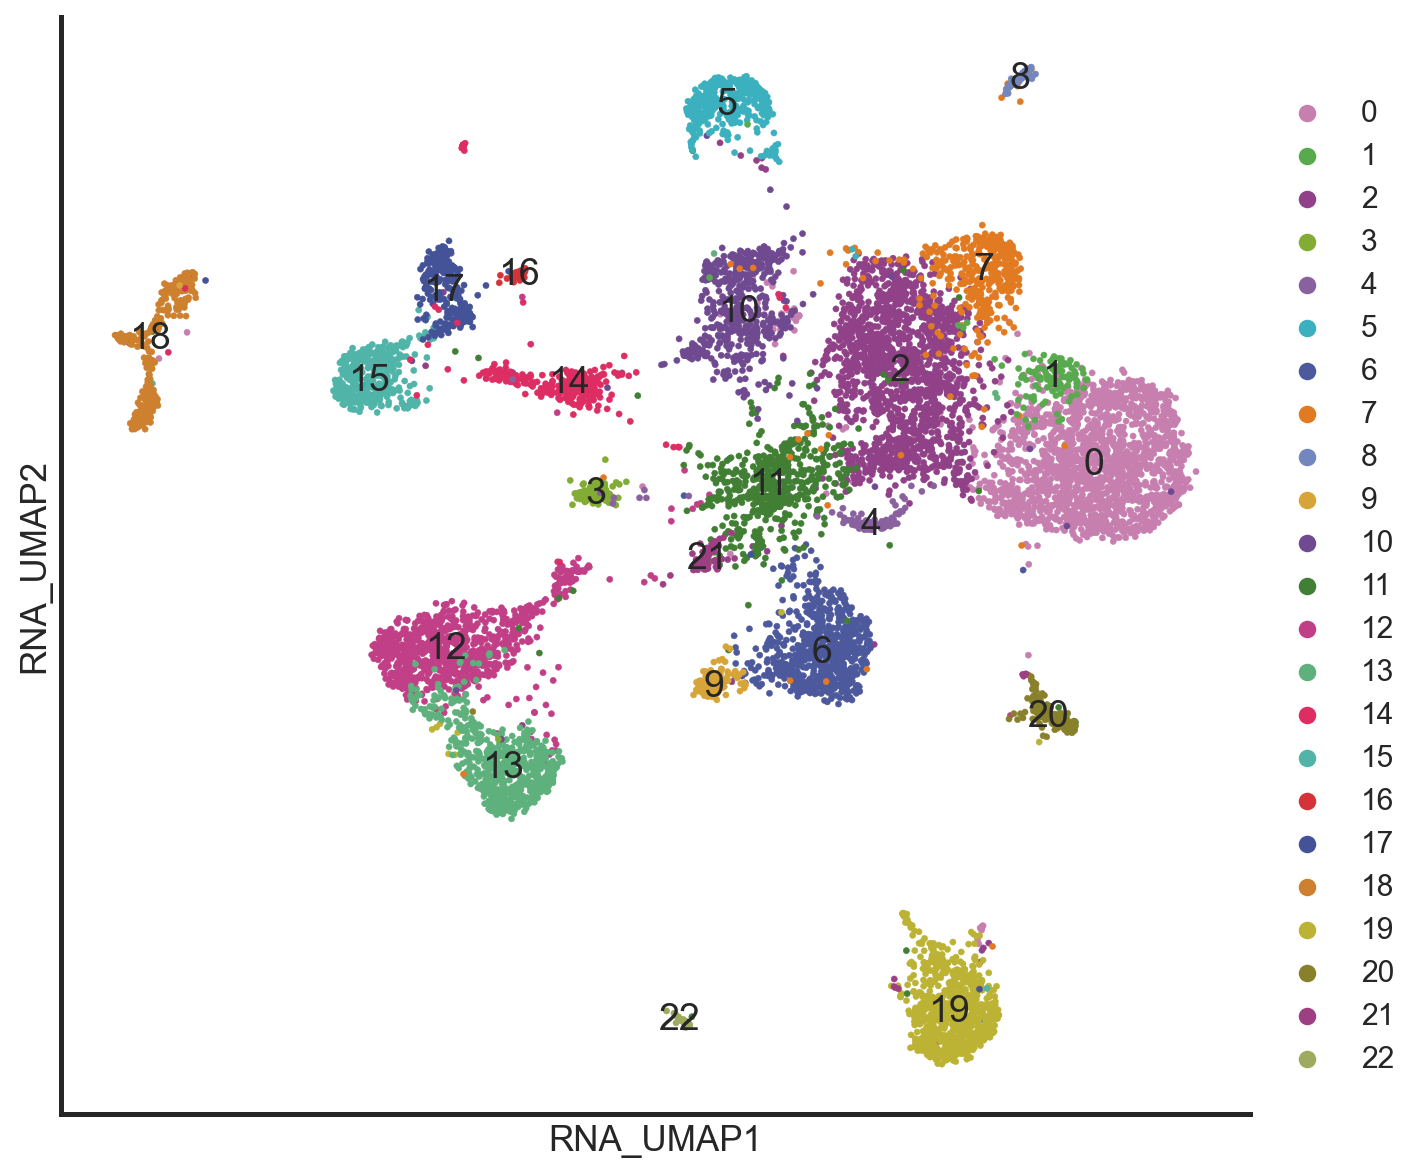

In [16]:
fig, ax = plt.subplots(figsize=(8,7))

sns.scatterplot(data = sample_info.sort_values(by = 'RNA_snn_res.1'),
                x = 'RNA_UMAP1', y = 'RNA_UMAP2', hue = 'RNA_Cluster_relabel',
                ax = ax, s=6, edgecolor=None,
                palette=sns.color_palette(Seurat23), alpha=1)
handles, labels = ax.get_legend_handles_labels()
hdls = []
lbls = []
for i in np.argsort([int(i) for i in labels]):
    hdls.append(handles[i])
    lbls.append(labels[i])
ax.legend(hdls, lbls, frameon=False, bbox_to_anchor=[1,0.95], markerscale=1)

for i in range(23):
    x = sample_info.query('RNA_Cluster_relabel == @i')['RNA_UMAP1'].median()
    y = sample_info.query('RNA_Cluster_relabel == @i')['RNA_UMAP2'].median()
    ax.text(x, y, str(i), fontsize=15, ha = 'center', va = 'center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('scripts_data/Fig2c_RNA_UMAP.pdf', bbox_inches='tight', transparent=True)
plt.show()

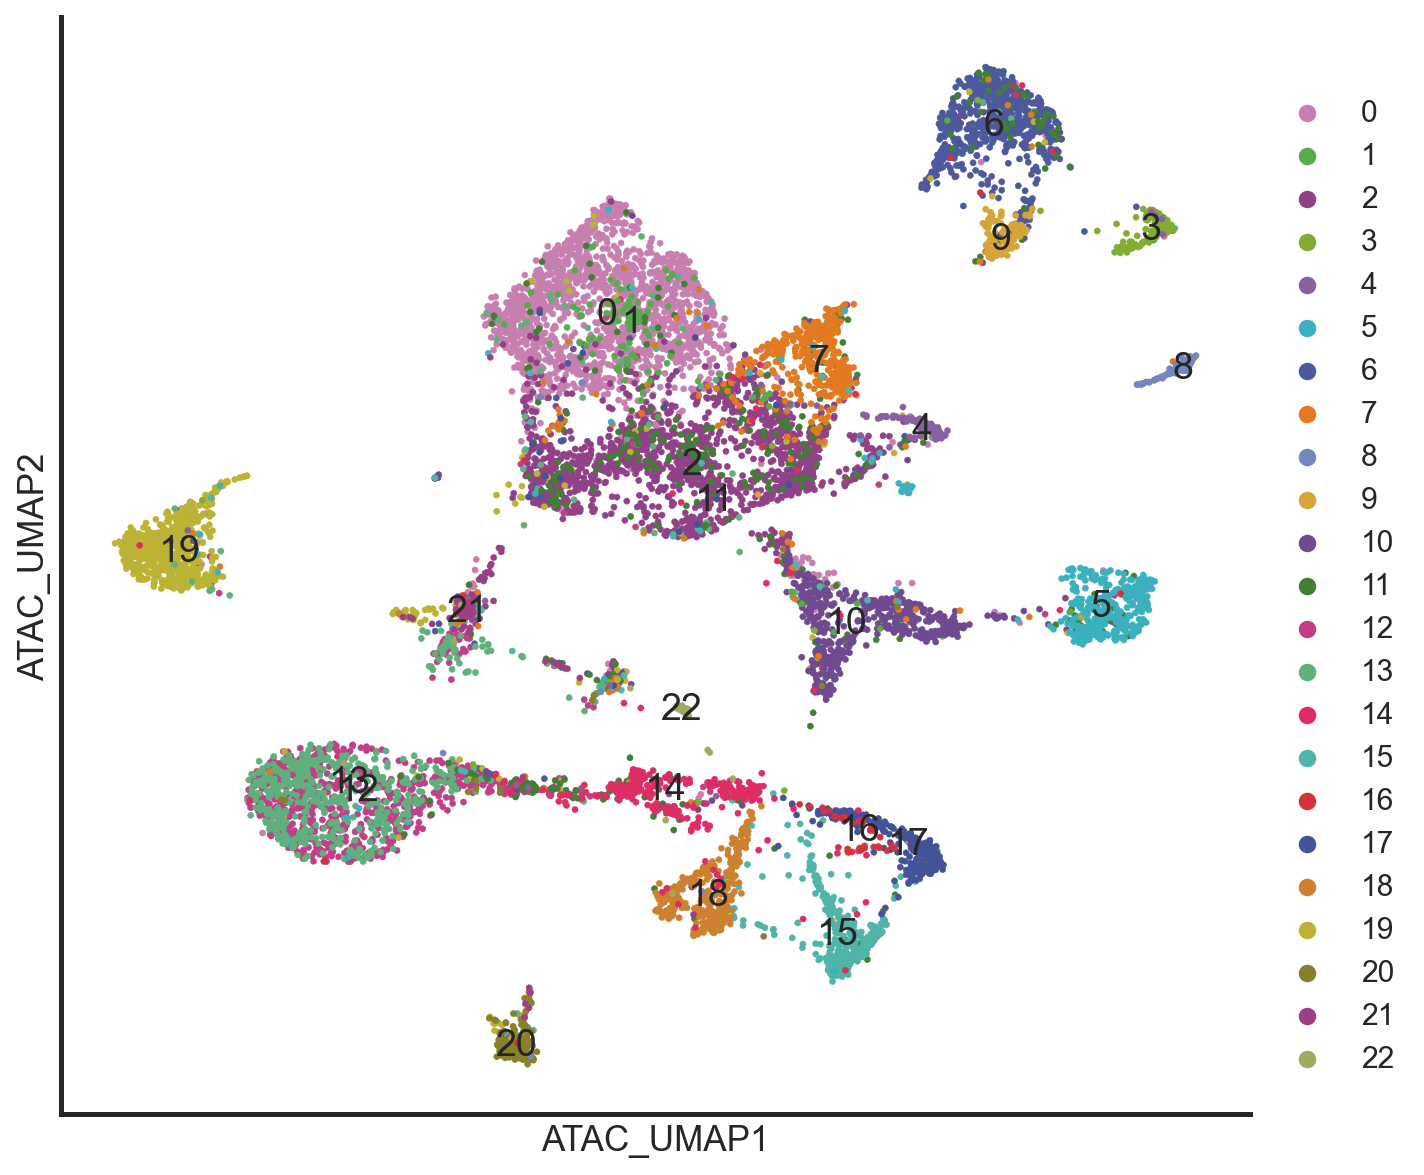

In [18]:
fig, ax = plt.subplots(figsize=(8,7))

sns.scatterplot(data = sample_info.sort_values(by = 'RNA_snn_res.1'),
                x = 'ATAC_UMAP1', y = 'ATAC_UMAP2', hue = 'RNA_Cluster_relabel',
                ax = ax, s=6, edgecolor=None,
                palette=sns.color_palette(Seurat23), alpha=1)
handles, labels = ax.get_legend_handles_labels()
hdls = []
lbls = []
for i in np.argsort([int(i) for i in labels]):
    hdls.append(handles[i])
    lbls.append(labels[i])
ax.legend(hdls, lbls, frameon=False, bbox_to_anchor=[1,0.95], markerscale=1)

for i in range(23):
    x = sample_info.query('RNA_Cluster_relabel == @i')['ATAC_UMAP1'].median()
    y = sample_info.query('RNA_Cluster_relabel == @i')['ATAC_UMAP2'].median()
    ax.text(x, y, str(i), fontsize=15, ha = 'center', va = 'center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('scripts_data/Fig2d_ATAC_UMAP.pdf', bbox_inches='tight', transparent=True)
plt.show()

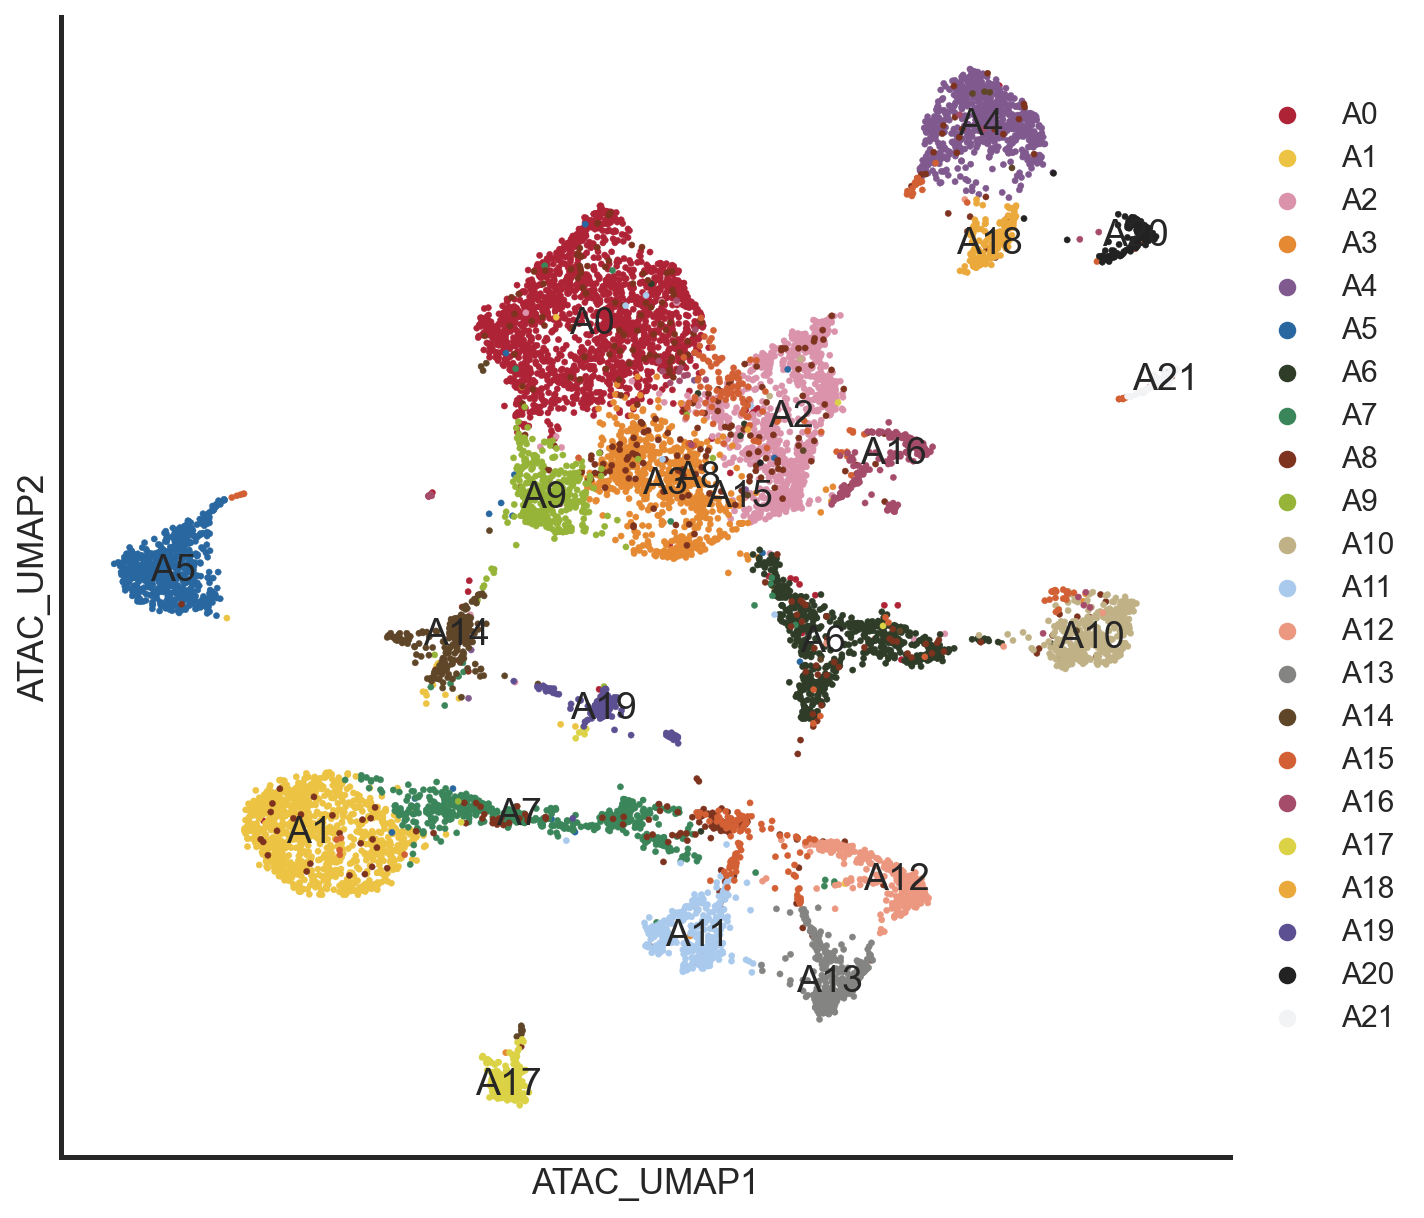

In [19]:
Kelly_ATAC = ['#af2337', '#ecc342', '#da93ab', '#e58932', '#80598f', '#2967a0',
              '#2f3c28', '#3b855a', '#7e331f', '#96b437', '#c0b286', '#a9c9ed',
              '#ec977f', '#848482', '#604628', '#d26034', '#a64c6b', '#dbd245',
              '#eba83b', '#5d5092', '#222222', '#f2f3f4']

fig, ax = plt.subplots(figsize=(8,7))

sns.scatterplot(data = sample_info.sort_values(by = 'ATAC_snn_res.1'),
                x = 'ATAC_UMAP1', y = 'ATAC_UMAP2', hue = 'ATAC_Cluster',
                ax = ax, s=6, edgecolor=None,
                palette=sns.color_palette(Kelly_ATAC), alpha=1)

ax.legend(frameon=False, bbox_to_anchor=[1,0.95], markerscale=1)

for i in ['A' + str(j) for j in range(22)]:
    x = sample_info.query('ATAC_Cluster == @i')['ATAC_UMAP1'].median()
    y = sample_info.query('ATAC_Cluster == @i')['ATAC_UMAP2'].median()
    ax.text(x, y, str(i), fontsize=15, ha = 'center', va = 'center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('scripts_data/Supp_related_fig2.pdf', bbox_inches='tight', transparent=True)
plt.show()

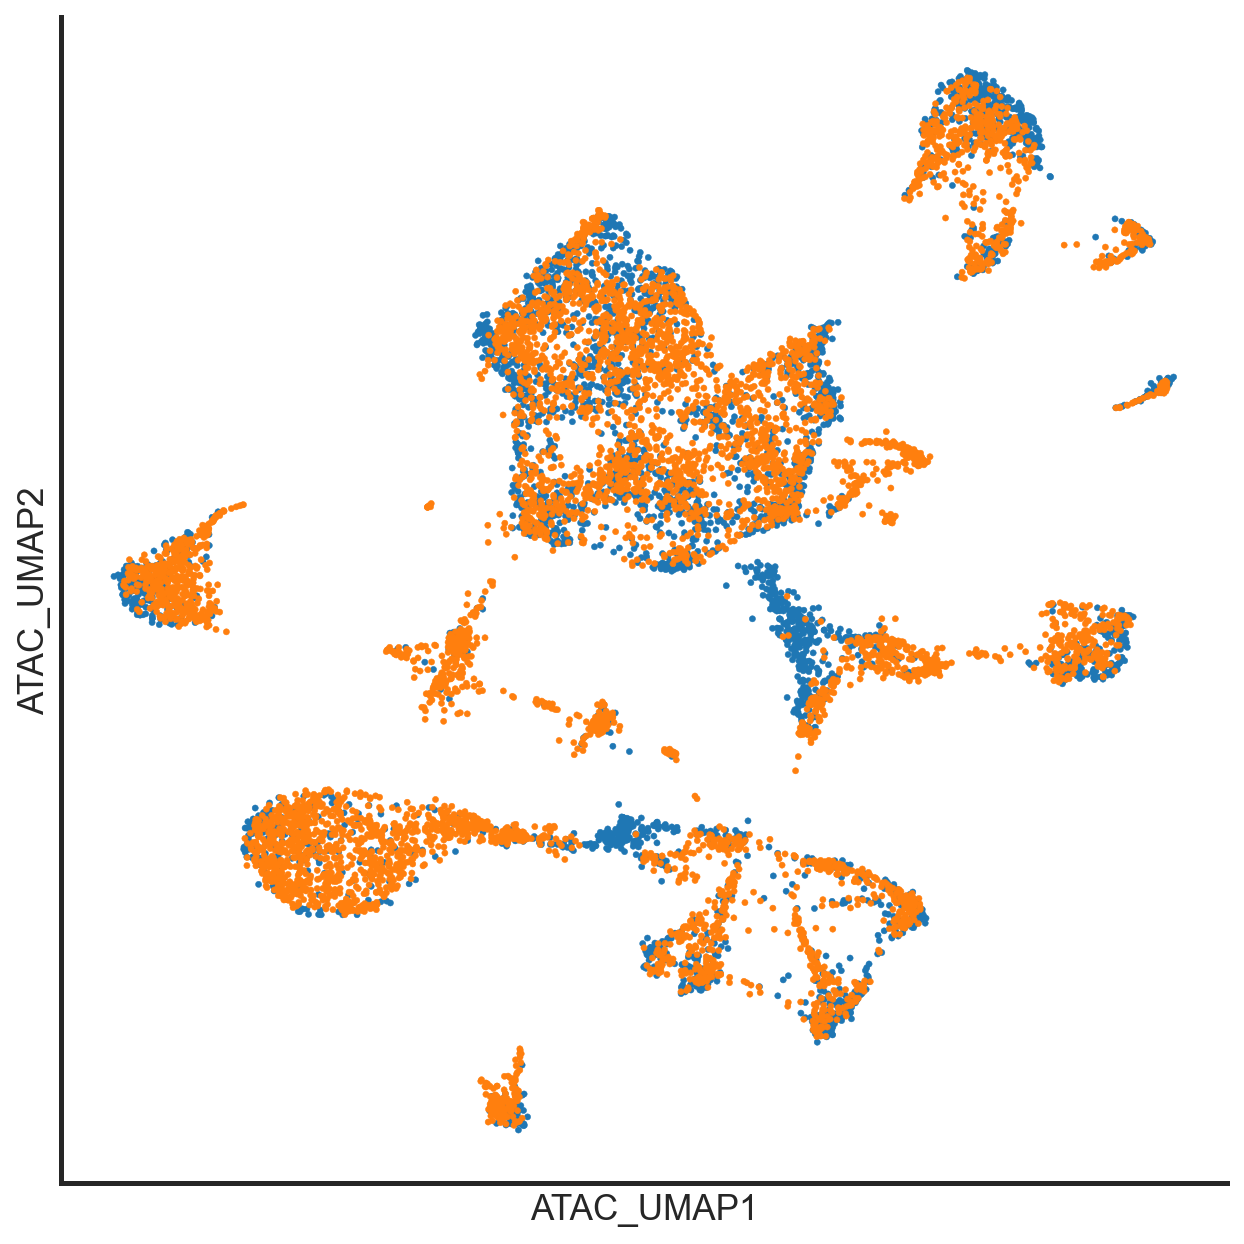

In [20]:
fig, ax = plt.subplots(figsize=(7,7))

sns.scatterplot(data = sample_info,
                x = 'ATAC_UMAP1', y = 'ATAC_UMAP2', hue = 'batch',
                ax = ax, s=6, edgecolor=None, alpha=1, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('scripts_data/Supp_related_fig2_atac_batch.pdf', bbox_inches='tight', transparent=True)
plt.show()

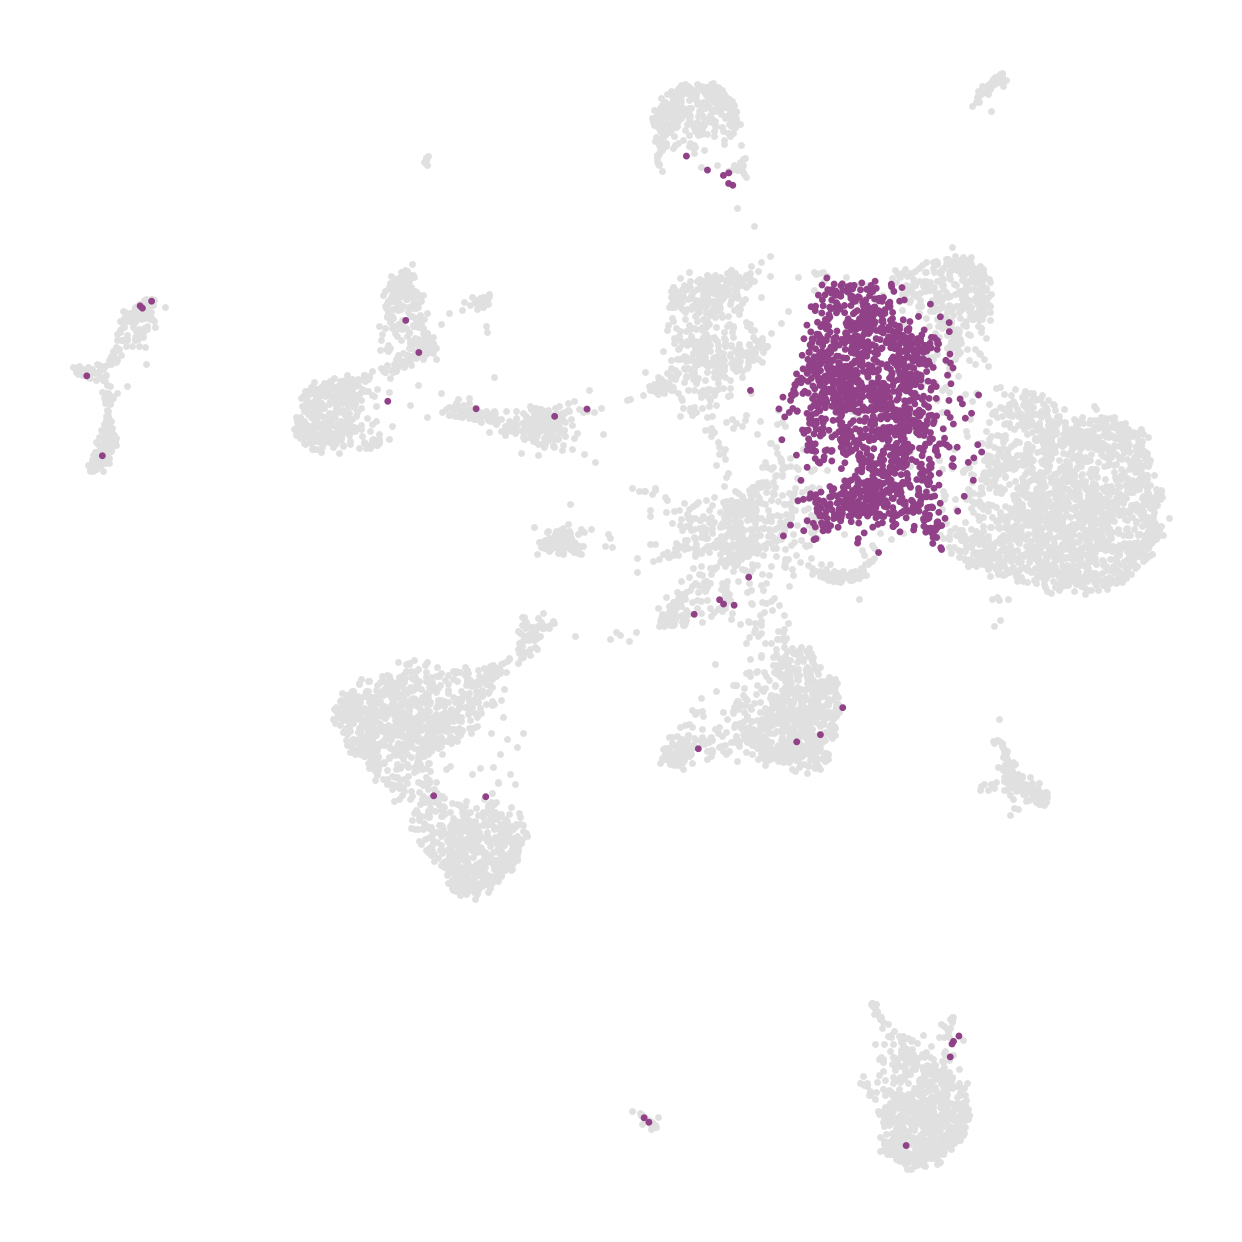

In [24]:
fig, ax = plt.subplots(figsize=(7,7))

L45_IT = sample_info.query('RNA_Cluster_relabel == 2')
the_rest_rna = sample_info.query('RNA_Cluster_relabel != 2')

ax.scatter(the_rest_rna['RNA_UMAP1'], the_rest_rna['RNA_UMAP2'], s=3, c='#e0e0e0')
ax.scatter(L45_IT['RNA_UMAP1'], L45_IT['RNA_UMAP2'], s=3, c=L45_IT['RNA_Cluster_colour'])
ax.axis('off')

plt.tight_layout()
plt.savefig('scripts_data/Fig3_L45_UMAP_RNA.pdf', bbox_inches='tight', transparent=True)
plt.show()

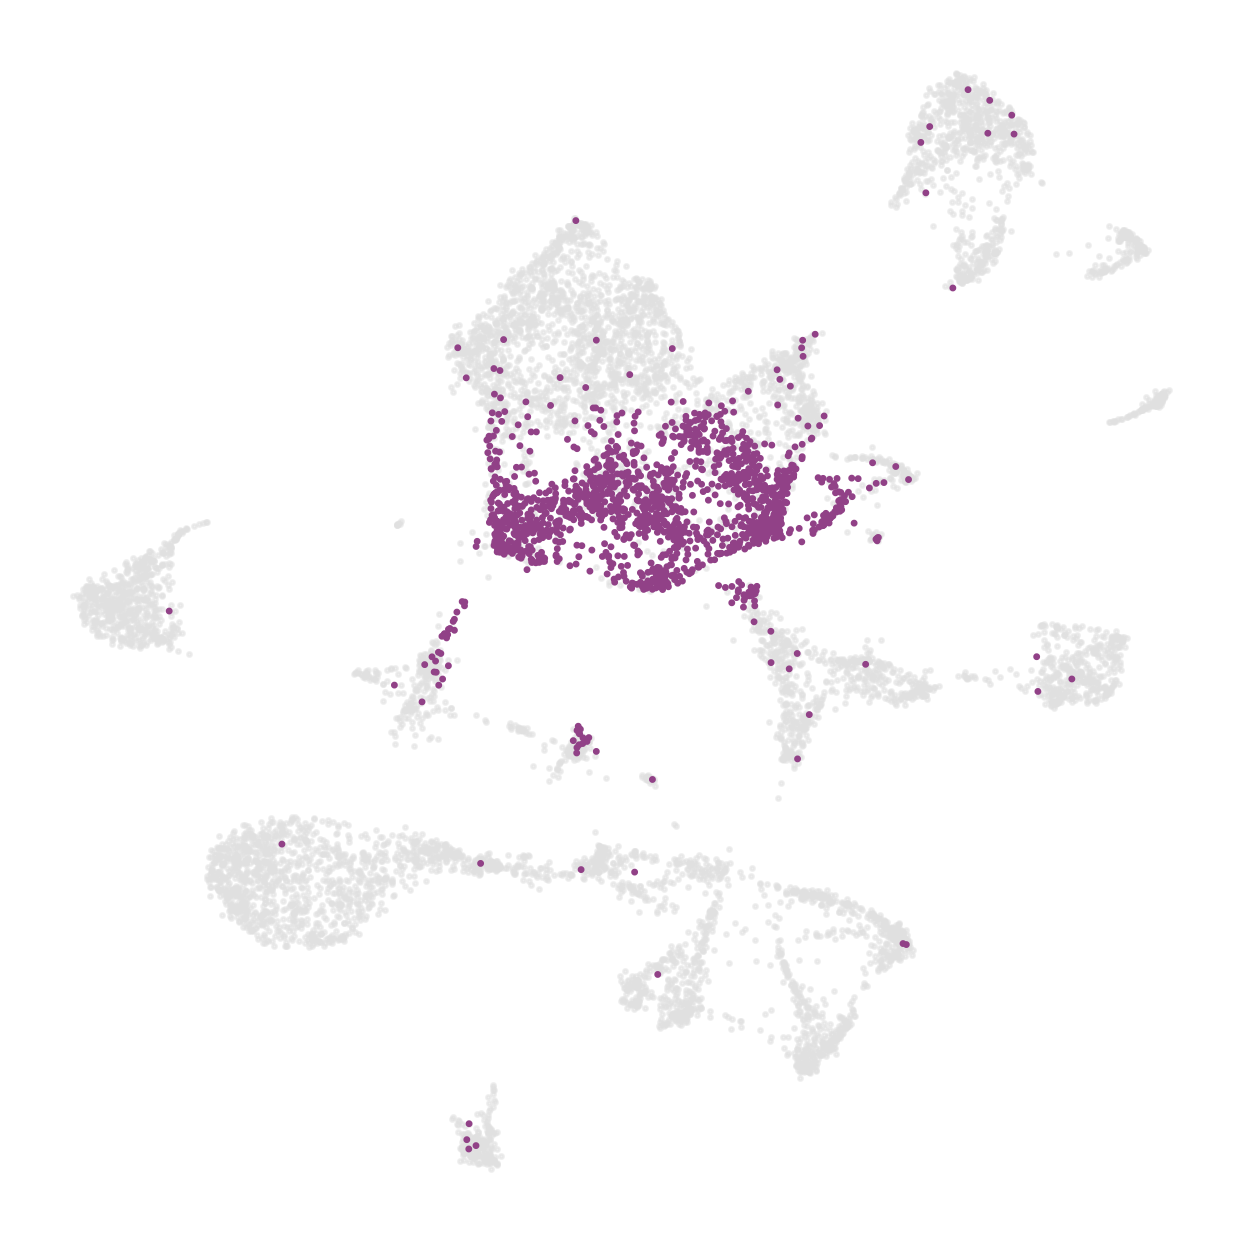

In [23]:
fig, ax = plt.subplots(figsize=(7,7))

L45_IT = sample_info.query('RNA_Cluster_relabel == 2')
the_rest_rna = sample_info.query('RNA_Cluster_relabel != 2')

ax.scatter(the_rest_rna['ATAC_UMAP1'], the_rest_rna['ATAC_UMAP2'], s=3, c='#e0e0e0', alpha=0.5)
ax.scatter(L45_IT['ATAC_UMAP1'], L45_IT['ATAC_UMAP2'], s=3, c=L45_IT['RNA_Cluster_colour'])
ax.axis('off')

plt.tight_layout()
plt.savefig('scripts_data/Fig3_L45_UMAP_ATAC.pdf', bbox_inches='tight', transparent=True)
plt.show()

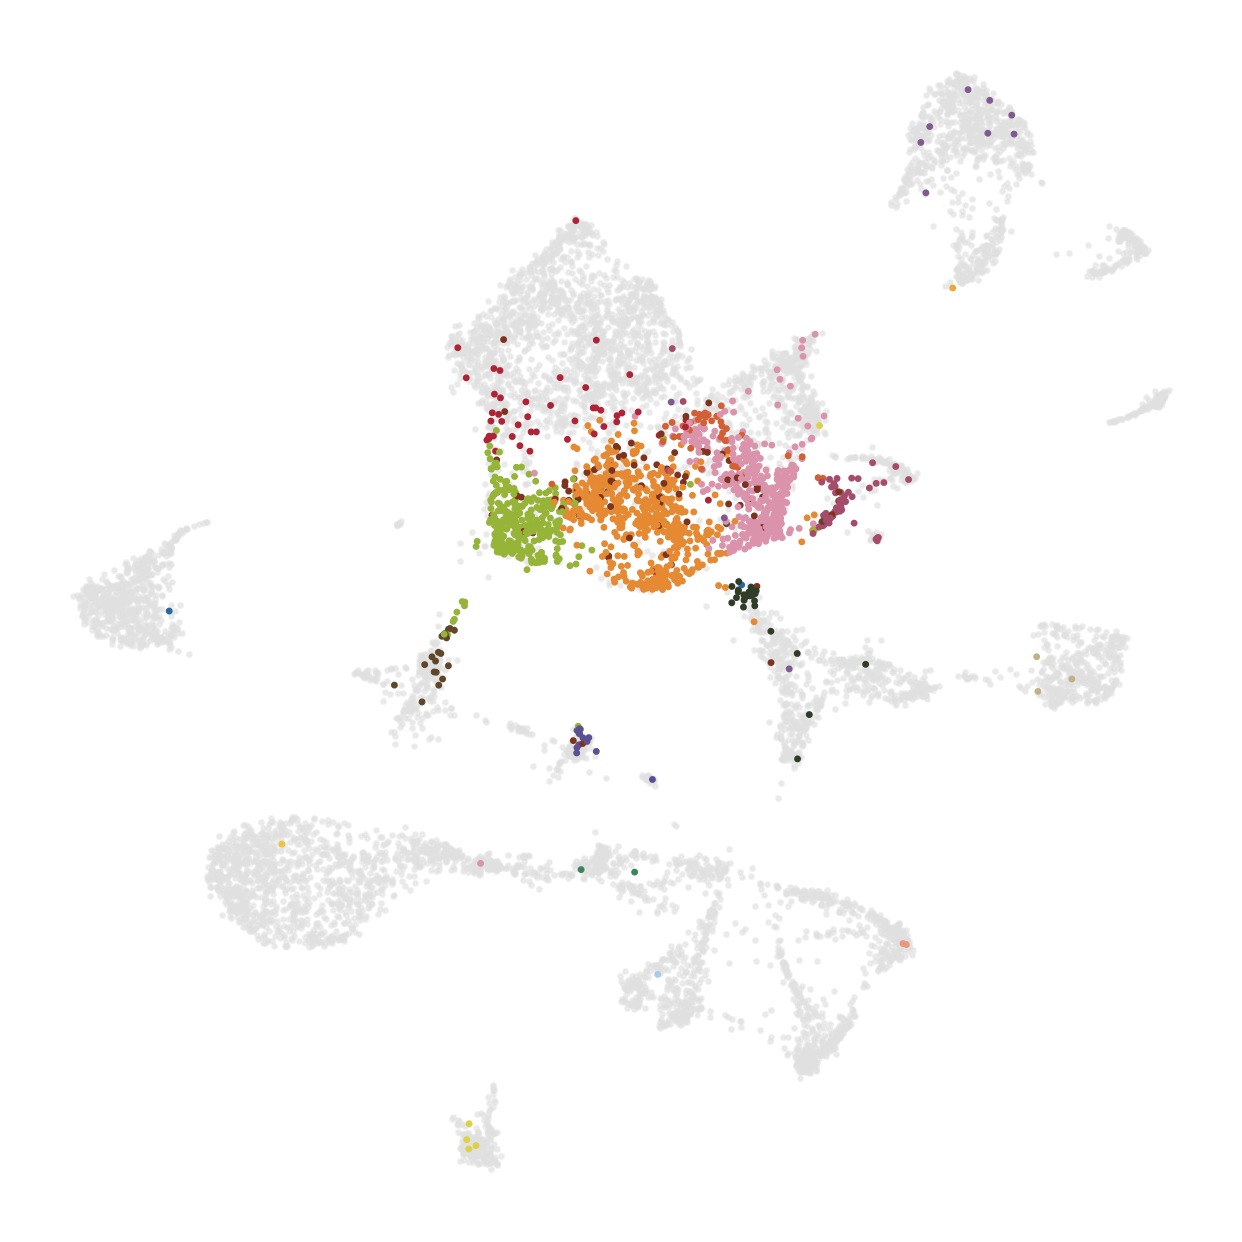

In [25]:
fig, ax = plt.subplots(figsize=(7,7))

L45_IT = sample_info.query('RNA_Cluster_relabel == 2')
the_rest_rna = sample_info.query('RNA_Cluster_relabel != 2')

ax.scatter(the_rest_rna['ATAC_UMAP1'], the_rest_rna['ATAC_UMAP2'], s=3, c='#e0e0e0', alpha=0.5)
ax.scatter(L45_IT['ATAC_UMAP1'], L45_IT['ATAC_UMAP2'], s=3, c=L45_IT['ATAC_Cluster_colour'])

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.set_xticks([])
# ax.set_yticks([])

ax.axis('off')

plt.tight_layout()
plt.savefig('scripts_data/Fig3_L45_UMAP_ATAC2.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Use Scanpy to make figures

In [26]:
import scanpy as sc
sc.set_figure_params(transparent=True, dpi=90)

In [27]:
adata = sc.read_csv('scripts_data/mCortex_all_expression_matrix.csv.gz').T
adata = adata[sample_info.index, :].copy()

In [28]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

In [30]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
adata.obsm['X_umap'] = sample_info.loc[:, ['RNA_UMAP1', 'RNA_UMAP2']].values
adata.obs['rna_cluster'] = sample_info['RNA_Cluster_relabel'].astype(str)
adata.obs['atac_cluster'] = sample_info['ATAC_Cluster']
adata.obs['batch'] = sample_info['batch']

# Marker gene plotting

In [32]:
dot_markers = ['Rbfox3', 'Slc32a1', 'Slc17a7', 'Ptgs2', 'Rorb', 'Slc17a8', 'Cxcl14', 'Npr3', 'Foxp2', 'Bmp3', 'Gfra1', 
               'Ccn2', 'Ndst4', 'Tac1', 'Drd2', 'Hap1', 'Scn5a', 'Cemip', 'Sst', 'Chodl', 'Elfn1',
               'Vip', 'Aqp4', 'Pdgfra', 'Olig1', 'Mal', 'Col1a2']

/Users/xichen/miniconda3/envs/scs/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'rna_cluster' as categorical
/Users/xichen/miniconda3/envs/scs/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'atac_cluster' as categorical
/Users/xichen/miniconda3/envs/scs/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remo

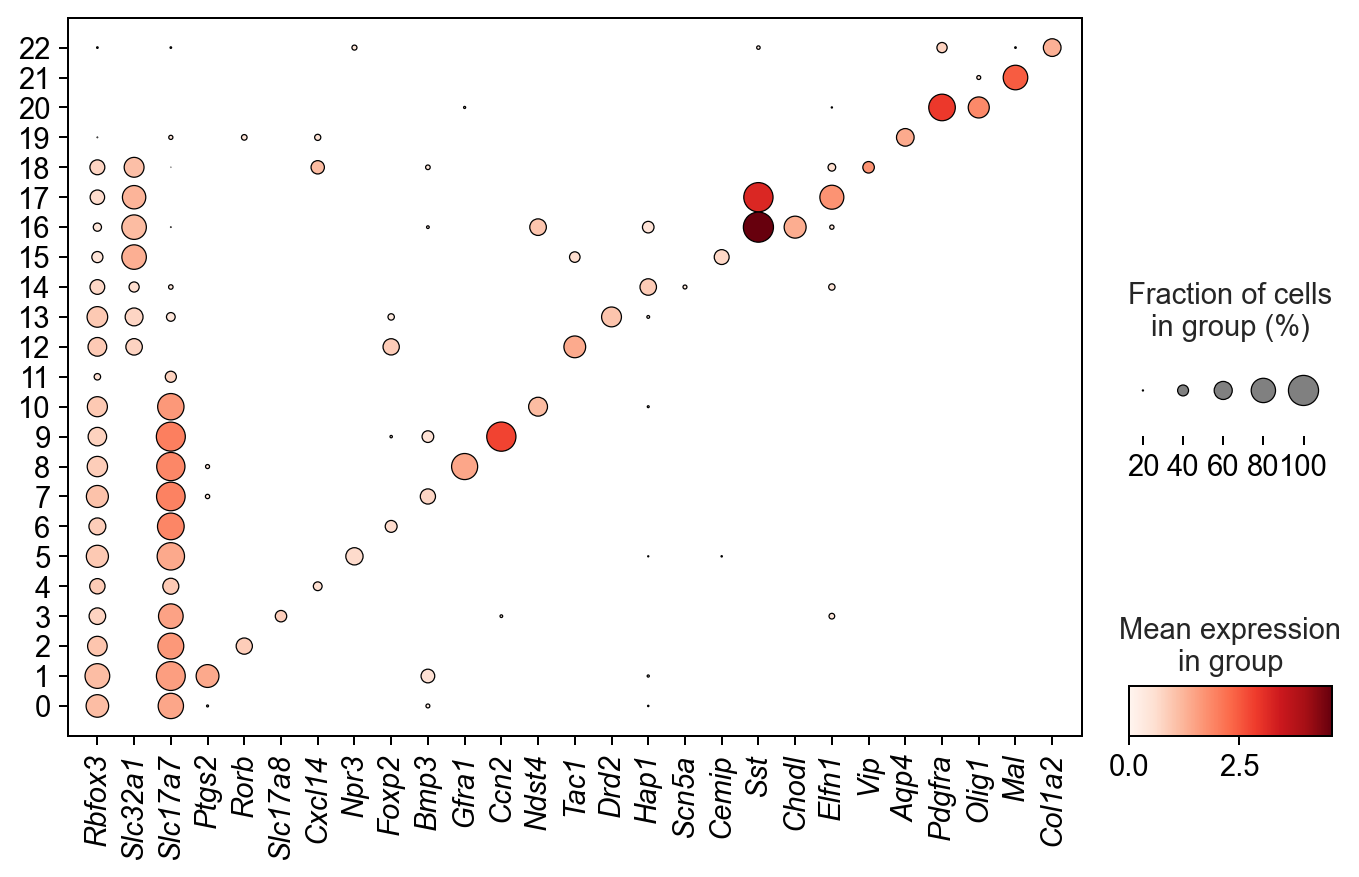

In [33]:
dt = sc.pl.dotplot(adata, dot_markers, 'rna_cluster', figsize=(9,5.25),
                   categories_order = [str(i) for i in reversed(range(23))],
                   return_fig=True, show=True)
dt.style(dot_edge_lw=0.5, cmap='Reds', dot_min=0.19, largest_dot=145)
dt.legend(width=1.5)
ax = dt.get_axes()
for xtl in ax['mainplot_ax'].get_xticklabels():
    xtl.set_style('italic')
plt.savefig('scripts_data/dotplot_dotplot.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [35]:
adata.obs['logC'] = np.log10(adata.obs['total_counts'])